# Frank-Wolfe variants for effective attacks on Inception V3 model

### Andrea Sipka, MSc Data Science, University of Padova

## Background information

**Adversarial image** is an image that tricks an image classifier, but not a human. If you, the human, see an adversarial image of a kitten, it will be obvious to you that the picture contains a kitten, but state-of-the-art image classifier with high accuracy rate, that this image was designed to fool, will misclassify it.

Many different adversarial attacks have been designed in the recent years, due to interest in computer vision, but also image recognition's increasing popularity in the application field - for example, in policing and security.

Adversarial attacks can be **white-box** or **black-box**. In white box attacks, the adversary has access to the target model, and in the black-box setting, the adversary has access to the input and the output of the model, but not model settings. It's important to point out that the "output" of the model, in the classification task, is a vector of probabilities of an image belonging to each class, rather than just a prediction class.

Adversarial attacks can also be **untargeted** or **targeted**. In an untargeted attack, we simply aim to misclassify the image into any other class, while in the targeted attack, we aim to misclassify an image into a particular class. For example, we might decide that an input image of a "kitten" should be misclassified as a "kitchen sink". As targeted attacks are harder, they are the ones covered in this notebook.

To formulate adversarial attack as an optimization problem, we let $\ell (\boldsymbol{x}, y)$ be the classification loss function of the deep neural network we are targeting with the attack, where $\boldsymbol{x} \in \Re^d$ is input and $y$ is a corresponding label.

In implementation below, the loss function used is categorical cross entropy, a popular loss function for training neural network to tackle multi-class classification problems. If we let $y_{tar}$ denote the target class of our attack, the function we are trying to minimize is:
$$ f (\boldsymbol{x}) = \ell (\boldsymbol{x}, y_{tar}) $$
subject to the following constraint, where $\boldsymbol{x}_{ori}$ denotes the original input:
$$ || \boldsymbol{x} - \boldsymbol{x}_{ori} ||_p \leq \epsilon $$
The normalization this implementation focuses on is $p = \infty$

## What is this notebook?

This notebook implements a few Frank-Wolfe variants which can be used for adversarial attacks on images.
Description of algorithms and theoretical background can be found in the paper "A Frank-Wolfe framework for efficient and effective adversarial attacks" [here](https://openreview.net/pdf?id=Hyewf3AqYX).

In addition to the white and black box implementations from the paper above, I present a modified Frank-Wolfe algorithm with momentum, from [this](https://arxiv.org/pdf/1811.10828.pdf) paper.

The main difference between two papers and the original Frank Wolfe method is as follows:
* Paper 1 (algorithms White box and Black box) calls the linear minimization oracle (which result is denoted by $v_t$ in algorith description) over a more relaxed constraint set $\chi_\lambda = \{ \boldsymbol{x} | \; || \boldsymbol{x} - \boldsymbol{x}_{ori}||_p \leq \lambda \epsilon \}$ for $\lambda \geq 1 $
* Paper 2 implements the momentum term which nudges the gradient in the direction of the previous step

In addition to algorithm implementation, some experimental results are presented.

Model being attacked is Inception V3 model (1st runner up for image classification in the The ImageNet Large Scale Visual Recognition Challenge 2015). Inception V3 is a complex convolutional neural network developed by researchers at Google and presented in the paper [here](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf). The Inception V3 model used here is pre-trained on an Imagenet training dataset for 1000 classes.

Dataset used for validation is Imagenet Validation dataset, which includes 50,000 images across 1000 classes. Github repository includes a sample of these (one image per class) and instructions on how to obtain full dataset can be found below.

The notebook is intended to be an educational tool. As such, explainability is favoured over performance (hence the use of the notebook). While effort was made to use efficient Python, the efficiency of code can be improved vastly by the use of sessions, GPU processing, and running through Terminal.

Code is heavily commented (as it should always be!) and every function in this notebook is docstringed. 
This means that if you want to know what a function (e.g. run_whitebox_attack()) does, you do this:

In [ ]:
print(run_whitebox_attack.__doc__)

In [1]:
import keras
from keras import backend as K
from keras import losses
from keras.applications import inception_v3
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import os.path
import os

%matplotlib inline

Using TensorFlow backend.


## Where did the data come from?

Imagenet validation set can be downloaded from Academic torents. However, it doesn't come with labels. The code box below should be ran only once, if you don't have labeled data, as it adds labels to the image names. All of this is mildly infuriating because the way labels are numbered in Keras isn't the same as the way labels are numbered in the actual Imagenet validation.

The following code blob assigns Keras compatible labels to all the files.

val.txt comes from [here](http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz)

Imagenet validation set torrent can be taken from [here](https://academictorrents.com/details/5d6d0df7ed81efd49ca99ea4737e0ae5e3a5f2e5)

Once downloaded, data was unzipped into the folder called "imagenetdata".

**Example**
* Orginal file name: "ILSVRC2012_val_00035997.JPEG"
* Original file label: 172
* New file name: "172_ILSVRC2012_val_00035997.JPEG"

In [ ]:
# Get current directory
currentdir = os.getcwd()

# Read in label file
f = open("val.txt","r")
y_val = f.read().strip().split("\n")
y_values = [int(x.split(' ')[1]) for x in y_val]

# Get file names from the folder
file_list = sorted(os.listdir("imagenetdata/"))

# Change the directory
os.chdir("imagenetdata/")

for i, filename in enumerate(file_list):
    # Create new filename by adding label_ to each name
    dst = str(y_values[i])+'_'+filename
    # Actual renaming
    os.rename(filename, dst)
    
# Go back to the original directory
os.chdir(currentdir)

## Load inception model

This will load pre-trained inception model with imagenet weights. If model does not exist, it will be downloaded.

In [2]:
# Load the Inception_V3 model with imagenet weights
inception_model = inception_v3.InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


## Function to use

In [3]:
def preprocess_img(filename):
    """
    Function takes in original image from file passed in,
    and coverts it into a format appropriate to be used with imagenet models
       
    Parameters:
    filename (str): Name of the image file from the imagenetdata folder

    Returns:
    nparray of shape (1, 299, 299, 3) which can be used on inception_v3 model
    """
    
    # load an image in PIL format
    original_image = load_img('imagenetdata/'+filename, target_size=(299, 299))
    
    # convert the PIL image (width, height) to a NumPy array (height, width, channel)
    numpy_image = img_to_array(original_image)
    
    # Convert the image into 4D Tensor (samples, height, width, channels) by adding an extra dimension to the axis 0.
    input_image = np.expand_dims(numpy_image, axis=0)
    
    # Preprocessing required for inception V3
    processed_image_inception_v3 = inception_v3.preprocess_input(input_image.copy())
    
    return processed_image_inception_v3

In [4]:
def generate_target(truelabel):
    """
    Function generates a target label for the attacks.
       
    Parameters:
    truelabel (int): Actual label based on ground truth

    Returns:
    1. nparray of shape 1, 1000 with all 0s and a single 1 for the target label
    2. intiger denoting target class
    """
    
    # Pick a random label other than the actual label
    target_class_index = random.choice(list(range(0, truelabel))+list(range(truelabel+1, 1000)))
    
    # Create an np array with all 0s but the 1 for the label
    target_class = np.zeros((1, 1000))
    target_class[0,target_class_index] = 1.
    
    return target_class_index, target_class

In [5]:
def run_classification(input_img, target_label):
    """
    Function uses the pre-loaded inception model to classify the image passed in
       
    Parameters:
    input_img (np array): Input image to be classified
    target_label (int): Target label for the attack

    Returns:
    1. A boolean that is True if the predicted target is the target class
    2. Integer denoting which class has been predicted
    """    
    
    # Run the model to predict based on pre-processed image
    predictions_inception_v3 = inception_model.predict(input_img)
    
    # Get the predicted label by finding the maximum value
    predicted_label = np.argmax(predictions_inception_v3)
    
    # Evaluate if the target label has been reached by comparing        
    target_reached = (target_label == predicted_label)
    
    return target_reached, predicted_label

In [129]:
# Placeholder variable where fake class comes in
target_class = K.zeros(shape=(1,1000))

# Calculate loss with categorical cross entropy
adversarial_loss = losses.categorical_crossentropy(target_class, inception_model.output) 

# Input image
input_img = inception_model.input 

# Compute gradients with respect to loss
grads = K.gradients(adversarial_loss, input_img)[0]

# Output for the functon
outputs = [grads]

# Function to use during attack
fetch_grads = K.function([input_img, target_class], outputs)

def evaluate_grads(input_img, tgt_class):
    """
    Function uses the keras functions described above to return 
    gradients w.r.t the categorical loss
       
    Parameters:
    input_img (np array): Input image to be classified
    tgt_class (np array): np array for target label

    Returns:
    Gradients of the image w.r.t. the loss
    """ 
    output = fetch_grads([input_img, tgt_class])
    
    return output[0]

In [82]:
# Placeholder variable where fake class comes in
target_class_black = K.zeros(shape=(1,1000))

# Calculate loss with categorical cross entropy
adversarial_loss_black = losses.categorical_crossentropy(target_class_black, inception_model.output) 

# Input image
input_img_black = inception_model.input 

# Output for the functon
outputs_black = [adversarial_loss_black]

# Function to use during attack
fetch_loss = K.function([input_img_black, target_class_black], outputs_black)

def evaluate_loss(input_img, tgt_class):
    """
    Function uses the keras functions described above to return loss
       
    Parameters:
    input_img (np array): Input image to be classified
    tgt_class (np array): np array for target label

    Returns:
    Categorical cross entropy loss
    """ 
    output = fetch_loss([input_img, tgt_class])
    
    return output[0]

In [7]:
def deprocess_image(x):
    """
    Function inverts the processing that was required for modeling.
    Used for display purposes.
    Shamefully lifted from the Keras examples directory.
       
    Parameters:
    x (np array): Input image to be deprocessed

    Returns:
    Deprocessed image
    """     
    
    x = np.copy(x)
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [300]:
def plot_sidebyside(img1, img2):
    """
    Function that plots two images side by side, and their predicted classes, alongiside probability confidence.
       
    Parameters:
    img1 (np array): Input image to be displayed on the left
    img2 (np array): Input image to be displayed on the right
    """ 
    f, axs= plt.subplots(1,2, figsize=(14,20))

    top_predicted_label = inception_v3.decode_predictions(inception_model.predict(img1), top=1)[0][0]
    axs[0].set_title('Predicted: %s (%f)' % (top_predicted_label[1], top_predicted_label[2]))
    axs[0].imshow(deprocess_image(img1))

    top_predicted_label = inception_v3.decode_predictions(inception_model.predict(img2), top=1)[0][0]
    axs[1].set_title('Predicted: %s (%f)' % (top_predicted_label[1], top_predicted_label[2]))
    axs[1].imshow(deprocess_image(img2))

In [ ]:
def plot_sidebyside_4(experiment, img1, img2, img3, img4):
    """
    Function that plots four images side by side, and their predicted classes and probability confidence.
       
    Parameters:
    experiment (int): Experiment ID
    img1 (np array): Input image to be displayed first from the left
    img2 (np array): Input image to be displayed second
    img3 (np array): Input image to be displayed third
    img4 (np array): Input image to be displayed fourth
    """ 
    print('Experiment ', experiment)
    f, axs= plt.subplots(1,4, figsize=(14,20))

    top_predicted_label = inception_v3.decode_predictions(inception_model.predict(img1), top=1)[0][0]
    axs[0].set_title('Original: %s \n(%f)' % (top_predicted_label[1], top_predicted_label[2]))
    axs[0].imshow(deprocess_image(img1))

    top_predicted_label = inception_v3.decode_predictions(inception_model.predict(img2), top=1)[0][0]
    axs[1].set_title('Target: %s \n(%f)' % (top_predicted_label[1], top_predicted_label[2]))
    axs[1].imshow(deprocess_image(img2))
    
    top_predicted_label = inception_v3.decode_predictions(inception_model.predict(img3), top=1)[0][0]
    axs[2].set_title('White box: %s \n(%f)' % (top_predicted_label[1], top_predicted_label[2]))
    axs[2].imshow(deprocess_image(img3))
    
    top_predicted_label = inception_v3.decode_predictions(inception_model.predict(img4), top=1)[0][0]
    axs[3].set_title('Momentum: %s \n(%f)' % (top_predicted_label[1], top_predicted_label[2]))
    axs[3].imshow(deprocess_image(img4))

## Attack algorithms

### White box attack with an $L_\infty$ norm.

***
#### Algorithm
- **input:**: number of iterations T, step size $\gamma_t$, $\lambda > 0$, original image $x_{\text{ori}}$
- $x_0 = x_{\text{ori}}$
- **for** $t = 1 ... T$ **do**:
    - $v_t = \text{argmin}_{v \in \chi_\lambda } \langle v, \nabla f(x_t) \rangle$
    - $d_t = v_t - x_t$
    - $x_{t+1} = x_t + \gamma_t d_t$
    - **if** $\lambda > 1$ **then**
        - $x_{t+1} = P_\chi (x_{t+1}) $
    - **end if**
- **end for**
- **output:** $x_T$

Note: closed form calculation for $v_t$ is $v_t = - \lambda \cdot \epsilon \cdot \text{sign} (\nabla f(x_t)) + x_{\text{ori}}$

***

In [285]:
def run_whitebox_attack(img_in, tgt_cl):
    """
    Function performs a targeted white box adversarial attack 
    on an imput image to the class of choice.
    Algorithm used is an adapted Frank-Wolfe.
       
    Parameters:
    img_in (np array): Input image to be classified
    tgt_cl (np array): np array for target label

    Returns:
    1. Original image
    2. New image
    3. Total time the algorithm took
    4. Distortion value
    5. Attack success boolean
    """ 
    
    x_ori = np.copy(img_in)
    target_class = np.copy(tgt_cl)
    
    epsilon_lambda = 0.05 
    gamma_t = 0.03 # stepsize
    
    #epsilon_lambda_todo = np.arange(0.005, 0.5, 0.005) # if looping for hyperparameter search
    #gammas = np.arange(0.001, 0.25, 0.001) # if looping for hyperparameter search    
    #for epsilon_lambda_t in epsilon_lambda_todo:
        #print('Running epsilon * lambda: ', epsilon_lambda_t)
        #epsilon_lambda = epsilon_lambda_t
    
    # ALGORITHM Step 2
    x = np.copy(x_ori)

    # ALGORITHM Step 3
    time_start = time.time()
    for iteration in range(10000):

        # Classifying with the model
        target_reached, _ = run_classification(x, targets)
        
        if target_reached:
            # if attack successful, stop iterating
            break

        # Getting gradients
        grad_values = evaluate_grads(x, target_class)

        # ALGORITHM Step 4: Linear Minimisation Oracle
        v_t = - epsilon_lambda * np.sign(grad_values) + x_ori

        # ALGORITHM Step 5
        d_t = v_t - x

        # ALGORITHM Step 6
        x = x + gamma_t * d_t

        # ALGORITHM Step 7
        x = x_ori + np.clip((x - x_ori), -(epsilon_lambda), (epsilon_lambda))

    time_total = time.time() - time_start
    
    # calculate distortion
    distortion = np.max(np.abs(x - x_ori))
    
    if target_reached:
        print('Attack successful.')
        
    #result_array.append([epsilon_lambda, target_reached, time_total, distortion])

    return x_ori, x, time_total, distortion, target_reached

### Black box attack with an $L_\infty$ norm and sampling from $N \sim$

***
#### Black box attack algorithm
- **input:**: number of iterations T, step size $\gamma_t$, $\lambda > 0$, original image $x_{\text{ori}}$
- $x_0 = x_{\text{ori}}$
- **for** $t = 1 ... T$ **do**:
    - $q_t = \text{ZERO_ORD_GRAD_EST} (x_t)$
    - $v_t = \text{argmin}_{v \in \chi_\lambda } \langle v, \nabla q_t \rangle$
    - $d_t = v_t - x_t$
    - $x_{t+1} = x_t + \gamma_t d_t$
    - **if** $\lambda > 1$ **then**
        - $x_{t+1} = P_\chi (x_{t+1}) $
    - **end if**
- **end for**
- **output:** $x_T$

Note: closed form calculation for $v_t$ is $v_t = - \lambda \cdot \epsilon \cdot \text{sign} (q_t) + x_{\text{ori}}$
***
#### Zeroth order gradient estimation algorithm (ZERO_ORD_GRAD_EST)
- **input:**: number of gradient estimation samples b, sampling parameter $\delta_t$
- $q = 0$
- **for** $i = 1 ... b$ **do**:
    - sample $u_i$ uniformly from standard Gaussian distribution $N(0,I)$
    - $q = q + \dfrac{d}{2 \delta_t b} (f(x_t + \delta_t u_i) - f(x_t - \delta_t u_i))u_i$
- **end for**
- **output:** $q$

***


Assuming the following hyperparameters (values from the source paper)
* $\lambda = 30$
* $T = 10000$
* $\epsilon = 0.05$
* $b = 25$
* Step size $\dfrac{0.03}{\sqrt{t}}$, starting from $\gamma = 0.03$, where t is iteration in T
* $\delta_t = 0.01$

In [202]:
def run_blackbox_attack(img_in, tgt_cl):
    """
    Function performs a black box targeted adversarial attack 
    on an input image to the class of choice.
    Algorithm used is an adapted Frank-Wolfe.
    Zeroth Order gradient estimation is used.
       
    Parameters:
    img_in (np array): Input image to be classified
    tgt_cl (np array): np array for target label

    Returns:
    1. Original image
    2. New image
    3. Total time the algorithm took
    4. Number of queries ran
    5. Distortion value
    6. Attack success boolean
    """ 
    
    x_ori = np.copy(img_in)
    target_class = np.copy(tgt_cl)
    
    max_queries = 500000
    epsilon = 0.5
    b = 25
    gamma_t = 0.03 #step size
    lmbda = 30
    num_queries = 0

    # ALGORITHM Step 2
    x = np.copy(x_ori)
        
    # ALGORITHM Step 3
    time_start = time.time()
        
    for iteration in range(1 , 10000):
        print('Running iteration: ', iteration)
                        
        # Get classification
        target_reached, _ = run_classification(x, targets)
        
        if target_reached:
            # Break the loop if attack was successful
            break
        if num_queries > max_queries:
            # Number of queries has been exceeded, break the loop
            print('Maximum number of queries exceeded.')
            break
        
        # Keep track of number of queries ran
        num_queries += b
                        
        # ALGORITHM Step 4: Linear Minimisation Oracle
        q_t = zero_ord_grad_est(x, target_class)
        
        # Step size calculation            
        gamma_t = 0.03 / ( iteration**0.5 )
            
        # ALGORITHM step 5
        v_t = - ( epsilon * lmbda * np.sign(q_t) ) + x_ori

        # ALGORITHM step 6
        d_t = v_t - x
            
        # ALGORITHM step 7
        x = x + gamma_t * d_t

        # ALGORITHM step 8-10
        x = x_ori + np.clip((x - x_ori), -(epsilon * lmbda), (epsilon * lmbda))
    
    time_total = time.time() - time_start
    # Calculate distortion
    distortion = np.max(np.abs(x - x_ori))
    
    if target_reached:
        print('Attack successful')
        

    return x_ori, x, time_total, num_queries, distortion, target_reached

In [200]:
def zero_ord_grad_est(x, target_class):
    """
    Function performs a zeroth Order gradient estimation.
       
    Parameters:
    x (np array): Input image
    target_class (np array): np array for target label

    Returns:
    Estimated gradient q
    """ 
    target_class = K.variable(value = target_class, dtype='float64')

    q = 0
    delta_t = 0.01
    
    # Range determined as doing 25 iterates (tune as required)
    for i in range(1,26):
        
        multiplier = 1 / (2 * delta_t * i)
        
        u_i = np.random.standard_normal(x.shape)
        
        xt_plus =  x + delta_t * u_i
        xt_minus = x - delta_t * u_i
        
        loss_plus = evaluate_loss(xt_plus, target_class)
        loss_minus = evaluate_loss(xt_minus, target_class)        
        
        q += q + multiplier * (loss_plus - loss_minus) * u_i
        
    return q

### White box attack with momentum

***
#### Algorithm
- **input:**: number of iterations T, step size $\gamma_t$, original image $x_{\text{ori}}$
- $x_0 = x_{\text{ori}}$ and $m_{-1} = \nabla f (x_o)$
- **for** $t = 1 ... T$ **do**:
    - $m_t = \beta \cdot  m_{t-1} + (1 - \beta) \nabla f (x_t)$
    - $v_t = \text{argmin}_{x \in \chi } \langle x, m_t \rangle$
    - $d_t = v_t - x_t$
    - $x_{t+1} = x_t + \gamma_t d_t$
- **end for**
- **output:** $x_T$

Note: closed form calculation for $v_t$ is $v_t = - \epsilon \cdot \text{sign} (m_t) + x_{\text{ori}}$

***

In [288]:
def run_whitebox_momentum_attack(img_in, tgt_cl):
    """
    Function performs a targeted white box adversarial attack 
    on an input image to the class of choice.
    Algorithm used is an adapted Frank-Wolfe with momentum term
       
    Parameters:
    img_in (np array): Input image to be classified
    tgt_cl (np array): np array for target label

    Returns:
    1. Original image
    2. New image
    3. Total time the algorithm took
    4. Distortion value
    5. Attack success boolean
    """ 
    
    # Hyperparameters
    gamma_t = 0.05     
    beta = 0.85
    epsilon = 0.1
    
    #epsilons = np.arange(0.005, 0.3, 0.005) # Used when looping

    # ALGORITHM Step 2
    x_ori = np.copy(img_in)
    target_class = np.copy(tgt_cl)
    
    x = np.copy(x_ori)
    m_t = evaluate_grads(x_ori, target_class)

    # ALGORITHM Step 3
    time_start = time.time()
    for iteration in range(10000):

        # Classify
        target_reached, _ = run_classification(x, targets)

        if target_reached:
            # Break the loop if attack has been successful
            break

        # Get gradients
        grad_values = evaluate_grads(x, target_class)

        # ALGORITHM Step 4
        m_t = beta * m_t + (1-beta) * grad_values

        # ALGORITHM Step 5: Linear Minimisation Oracle
        v_t = - epsilon * np.sign(m_t) + x_ori

        # ALGORITHM Step 6
        d_t = v_t - x

        # ALGORITHM Step 7
        x = x + gamma_t * d_t

    time_total = time.time() - time_start
    
    # Calculate distortion
    distortion = np.max(np.abs(x - x_ori))
    
    if target_reached:
        print('Attack successful')
        
    return x_ori, x, time_total, distortion, target_reached

### Black box attack with momentum

***

In [374]:
def run_blackbox_momentum_attack(img_in, tgt_cl):
    """
    Function performs a black box targeted adversarial attack 
    on an input image to the class of choice.
    Algorithm used is an adapted Frank-Wolfe.
    Zeroth Order gradient estimation is used.
       
    Parameters:
    img_in (np array): Input image to be classified
    tgt_cl (np array): np array for target label

    Returns:
    1. Original image
    2. New image
    3. Total time the algorithm took
    4. Number of queries ran
    5. Distortion value
    6. Attack success boolean
    """ 
    
    x_ori = np.copy(img_in)
    target_class = np.copy(tgt_cl)
    
    # Hyperparameters
    max_queries = 500000
    epsilon = 0.05
    b = 25
    gamma_t = 0.03 #step size
    lmbda = 30
    num_queries = 0
    beta = 0.999

    # ALGORITHM Step 2
    x = np.copy(x_ori)
    time_start = time.time()
    m_t = zero_ord_grad_est(x_ori, target_class)
        
    # ALGORITHM Step 3
    for iteration in range(1 , 10000):
        
        if iteration%10 == 0:
            print('Running iteration: ', iteration)
        
        # Classify to evaluate if target has been reached
        target_reached, _ = run_classification(x, targets)
        
        if target_reached:
            # Target has been reached, break the loop
            break
        
        if num_queries > max_queries:
            print('Maximum number of queries exceeded.')
            break
                
        # Track the number of queries ran
        num_queries += b
                        
        # ALGORITHM Step 4
        q_t = zero_ord_grad_est(x, target_class)
        
        # ALGORITHM Step 5
        m_t = beta * m_t + (1-beta) * q_t
                    
        # ALGORITHM step 6
        v_t = - ( epsilon * lmbda * np.sign(m_t) ) + x_ori

        # ALGORITHM step 7
        d_t = v_t - x
            
        # STEP SIZE CALCULATION            
        gamma_t = 0.08 / ( iteration**0.5 )

        # ALGORITHM step 8
        x = x + gamma_t * d_t
    
    time_total = time.time() - time_start
    
    # Calculate distortion
    distortion = np.max(np.abs(x - x_ori))
    
    if target_reached:
        print('Attack successful')
        
    return x_ori, x, time_total, num_queries, distortion, target_reached

## Choose an image to attack

* Option 1 randomly chooses an image from an imagenet data folder
* Option 2 requires a filename for a file from the same folder. Filename '242_ILSVRC2012_val_00031314.JPEG' is a cute dog

In [ ]:
# Option 1 : Randomly choose an image
filename = random.choice(os.listdir("imagenetdata/"))

In [364]:
# Option 2: Choose a specific image
filename = '242_ILSVRC2012_val_00031314.JPEG'

## Preprocessing image and selecting target class

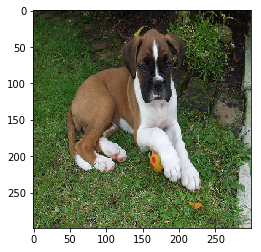

In [365]:
# Preprocess image
processed_image_inception_v3 = preprocess_img(filename)

plt.imshow(deprocess_image(processed_image_inception_v3))

In [179]:
# What is the ground truth label for this image?

truelabel = int(filename[0 : filename.find('_')])
truelabelar = np.zeros((1, 1000))
truelabelar[0,truelabel] = 1.
print('Ground truth Label is %s, class number %i' % (inception_v3.decode_predictions(truelabelar)[0][0][1], truelabel))

# What is the model predicting now?

top_predicted_label = inception_v3.decode_predictions(inception_model.predict(processed_image_inception_v3), top=1)[0][0]
print('Predicted Label is %s, with probability %f' % (top_predicted_label[1], top_predicted_label[2]))

# Has the model got it right?

predicted_correctly, predicted_label  = run_classification(processed_image_inception_v3, truelabel)
print('Predicted correctly?', predicted_correctly )

Ground truth Label is boxer, class number 242
Predicted Label is boxer, with probability 0.948531
Predicted correctly? True


Target Label is anemone_fish, class number 393
Example image:


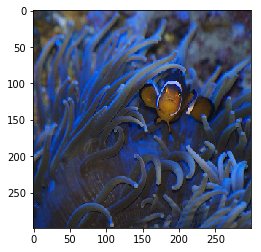

In [183]:
# Generate target class randomly

targets, target_class = generate_target(truelabel)
print('Target Label is %s, class number %i' % (inception_v3.decode_predictions(target_class)[0][0][1], targets))

# Show an example of the target class
filename_ex = [i for i in sorted(os.listdir("imagenetdata/")) if str(targets) == i[0 : i.find('_')]][0]
print('Example image:')
plt.imshow(deprocess_image(preprocess_img(filename_ex)))

*** 
# Examples of attack

### Whitebox base algorithm attack

Running epsilon lambda:  0.005
Attack successful.
Attack successful? True
--- distortion =  0.0048220158
--- attack time:  333.39895009994507 seconds


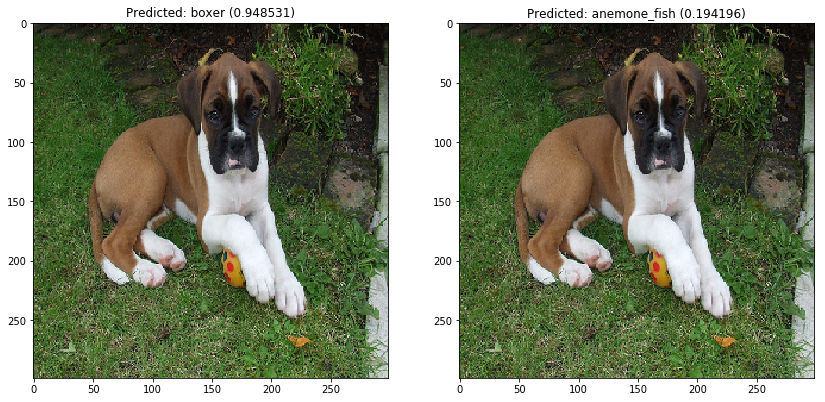

In [193]:
original_image, new_image, time_took, distortion, targetreached = run_whitebox_attack(processed_image_inception_v3, target_class)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- attack time: ",time_took,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

### Whitebox with momentum attack

Attack successful? True
--- distortion =  0.030629039
--- attack time:  4.652271270751953 seconds


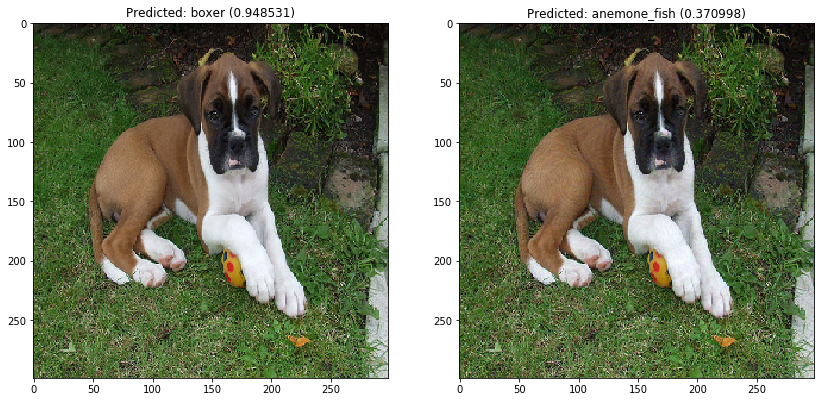

In [198]:
original_image, new_image, time_took, distortion, targetreached = run_whitebox_momentum_attack(processed_image_inception_v3, target_class)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- attack time: ",time_took,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

### Blackbox attack

Running iteration:  1
Running iteration:  2
Running iteration:  3
Running iteration:  4
Running iteration:  5
Running iteration:  6
Running iteration:  7
Running iteration:  8
Running iteration:  9
Running iteration:  10
Running iteration:  11
Running iteration:  12
Running iteration:  13
Running iteration:  14
Running iteration:  15
Running iteration:  16
Running iteration:  17
Running iteration:  18
Running iteration:  19
Running iteration:  20
Running iteration:  21
Running iteration:  22
Running iteration:  23
Running iteration:  24
Running iteration:  25
Running iteration:  26
Running iteration:  27
Running iteration:  28
Running iteration:  29
Running iteration:  30
Running iteration:  31
Running iteration:  32
Running iteration:  33
Running iteration:  34
Running iteration:  35
Running iteration:  36
Running iteration:  37
Running iteration:  38
Running iteration:  39
Running iteration:  40
Running iteration:  41
Running iteration:  42
Running iteration:  43
Running iteration:  

Running iteration:  347
Running iteration:  348
Running iteration:  349
Running iteration:  350
Running iteration:  351
Running iteration:  352
Running iteration:  353
Running iteration:  354
Running iteration:  355
Running iteration:  356
Running iteration:  357
Running iteration:  358
Running iteration:  359
Running iteration:  360
Running iteration:  361
Running iteration:  362
Running iteration:  363
Running iteration:  364
Running iteration:  365
Running iteration:  366
Running iteration:  367
Running iteration:  368
Running iteration:  369
Running iteration:  370
Running iteration:  371
Running iteration:  372
Running iteration:  373
Running iteration:  374
Running iteration:  375
Running iteration:  376
Running iteration:  377
Running iteration:  378
Running iteration:  379
Running iteration:  380
Running iteration:  381
Running iteration:  382
Running iteration:  383
Running iteration:  384
Running iteration:  385
Running iteration:  386
Running iteration:  387
Running iteratio

Running iteration:  689
Running iteration:  690
Running iteration:  691
Running iteration:  692
Running iteration:  693
Running iteration:  694
Running iteration:  695
Running iteration:  696
Running iteration:  697
Running iteration:  698
Running iteration:  699
Running iteration:  700
Running iteration:  701
Running iteration:  702
Running iteration:  703
Running iteration:  704
Running iteration:  705
Running iteration:  706
Running iteration:  707
Running iteration:  708
Running iteration:  709
Running iteration:  710
Running iteration:  711
Running iteration:  712
Running iteration:  713
Running iteration:  714
Running iteration:  715
Running iteration:  716
Running iteration:  717
Running iteration:  718
Running iteration:  719
Running iteration:  720
Running iteration:  721
Running iteration:  722
Running iteration:  723
Running iteration:  724
Running iteration:  725
Running iteration:  726
Running iteration:  727
Running iteration:  728
Running iteration:  729
Running iteratio

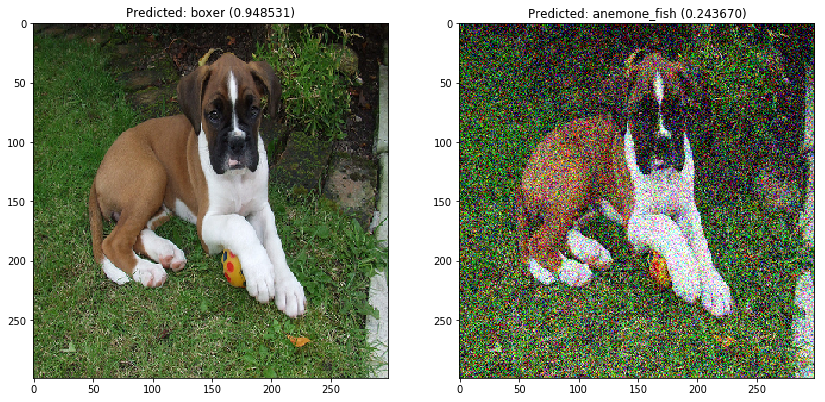

In [203]:
original_image, new_image, time_took, total_queres, distortion, targetreached = run_blackbox_attack(processed_image_inception_v3, target_class)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- total queries: ",total_queres,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)


In [ ]:
## Black box with momentum

original_image, new_image, time_took, total_queres, distortion, targetreached = run_blackbox_momentum_attack(processed_image_inception_v3, target_class_fish)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- total queries: ",total_queres,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

Running iteration:  10
Running iteration:  20
Running iteration:  30
Running iteration:  40
Running iteration:  50
Running iteration:  60
Running iteration:  70
Running iteration:  80
Running iteration:  90
Running iteration:  100
Running iteration:  110
Running iteration:  120
Running iteration:  130
Running iteration:  140
Running iteration:  150
Running iteration:  160
Running iteration:  170
Running iteration:  180
Running iteration:  190
Running iteration:  200
Running iteration:  210
Running iteration:  220
Running iteration:  230
Running iteration:  240
Running iteration:  250
Running iteration:  260
Running iteration:  270
Running iteration:  280
Running iteration:  290
Running iteration:  300
Running iteration:  310
Running iteration:  320
Running iteration:  330
Running iteration:  340
Running iteration:  350
Running iteration:  360
Running iteration:  370
Running iteration:  380
Running iteration:  390
Running iteration:  400
Running iteration:  410
Running iteration:  420
R

***
## Hyperparameter tuning for whitebox base model

Important note: I was time pressured and didn't build in nice parameter tuning functionality in attacks. The following code bits have been ran after modifying attack functions to loop through desired hyperparameter

### Tuning $\gamma$ (from 0.001 to 0.25, increments of 0.001)

In [258]:
results_white_gamma = []
results_white_gamma = run_whitebox_attack(processed_image_inception_v3, target_class, results_white_gamma)
results_white_gamma = pd.DataFrame(results_white_gamma, columns=['gamma_t', 'attack_successful','time','distortion'])

Running gamma:  0.001
Running gamma:  0.002
Running gamma:  0.003
Running gamma:  0.004
Running gamma:  0.005
Running gamma:  0.006
Running gamma:  0.007
Running gamma:  0.008
Running gamma:  0.009000000000000001
Running gamma:  0.010000000000000002
Running gamma:  0.011
Running gamma:  0.012
Running gamma:  0.013000000000000001
Running gamma:  0.014000000000000002
Running gamma:  0.015
Running gamma:  0.016
Running gamma:  0.017
Running gamma:  0.018000000000000002
Running gamma:  0.019000000000000003
Running gamma:  0.02
Running gamma:  0.021
Running gamma:  0.022000000000000002
Running gamma:  0.023
Running gamma:  0.024
Running gamma:  0.025
Running gamma:  0.026000000000000002
Running gamma:  0.027000000000000003
Running gamma:  0.028
Running gamma:  0.029
Running gamma:  0.030000000000000002
Running gamma:  0.031
Running gamma:  0.032
Running gamma:  0.033
Running gamma:  0.034
Running gamma:  0.035
Running gamma:  0.036000000000000004
Running gamma:  0.037000000000000005
Running

In [ ]:
results_white_gamma

In [263]:
print('Number of successful attacks: ', results_white_gamma[results_white_gamma.attack_successful == True].shape[0])
print('Number of unsuccessful attacks: ', results_white_gamma[results_white_gamma.attack_successful == False].shape[0])

Number of successful attacks:  249
Number of unsuccessful attacks:  0


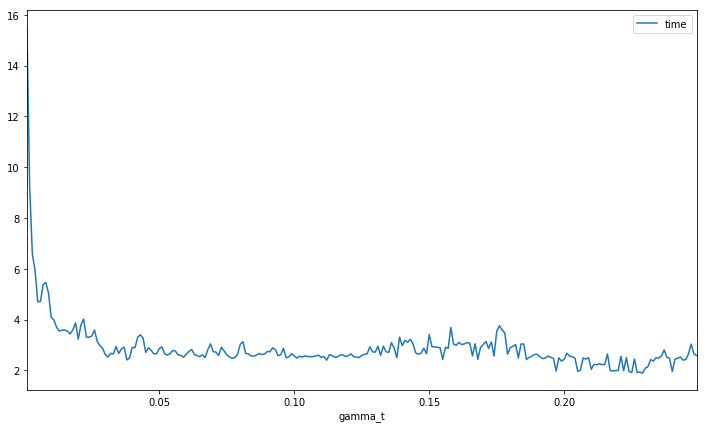

In [264]:
results_white_gamma.sort_values(by=['gamma_t']).plot(x ='gamma_t', y='time', kind = 'line',  figsize=(12,7))

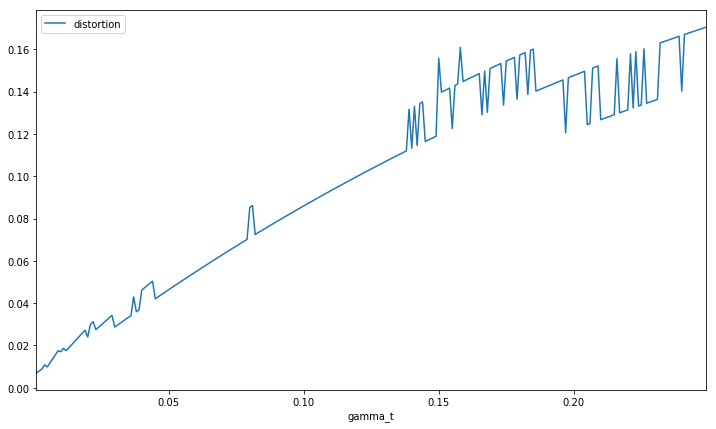

In [265]:
results_white_gamma.sort_values(by=['gamma_t']).plot(x ='gamma_t', y='distortion', kind = 'line',  figsize=(12,7))

### Tunning $\epsilon \cdot \lambda$ (from 0.005 to 0.5, increments of 0.005)

In [277]:
results_white_epslam = []
results_white_epslam = run_whitebox_attack(processed_image_inception_v3, target_class, results_white_epslam)
results_white_epslam_df = pd.DataFrame(results_momentum_epsilon, columns=['epsilon_lambda', 'attack_successful', 'time', 'distortion'])

Running epsilon * lambda:  0.005
Running epsilon * lambda:  0.01
Running epsilon * lambda:  0.015
Running epsilon * lambda:  0.02
Running epsilon * lambda:  0.025
Running epsilon * lambda:  0.030000000000000002
Running epsilon * lambda:  0.034999999999999996
Running epsilon * lambda:  0.04
Running epsilon * lambda:  0.045
Running epsilon * lambda:  0.049999999999999996
Running epsilon * lambda:  0.055
Running epsilon * lambda:  0.06
Running epsilon * lambda:  0.065
Running epsilon * lambda:  0.07
Running epsilon * lambda:  0.07500000000000001
Running epsilon * lambda:  0.08
Running epsilon * lambda:  0.085
Running epsilon * lambda:  0.09000000000000001
Running epsilon * lambda:  0.095
Running epsilon * lambda:  0.1
Running epsilon * lambda:  0.10500000000000001
Running epsilon * lambda:  0.11
Running epsilon * lambda:  0.115
Running epsilon * lambda:  0.12000000000000001
Running epsilon * lambda:  0.125
Running epsilon * lambda:  0.13
Running epsilon * lambda:  0.135
Running epsilon * 

In [ ]:
results_white_epslam_df

In [278]:
print('Number of successful attacks: ', results_white_epslam_df[results_white_epslam_df.attack_successful == True].shape[0])
print('Number of unsuccessful attacks: ', results_white_epslam_df[results_white_epslam_df.attack_successful == False].shape[0])

Number of successful attacks:  59
Number of unsuccessful attacks:  0


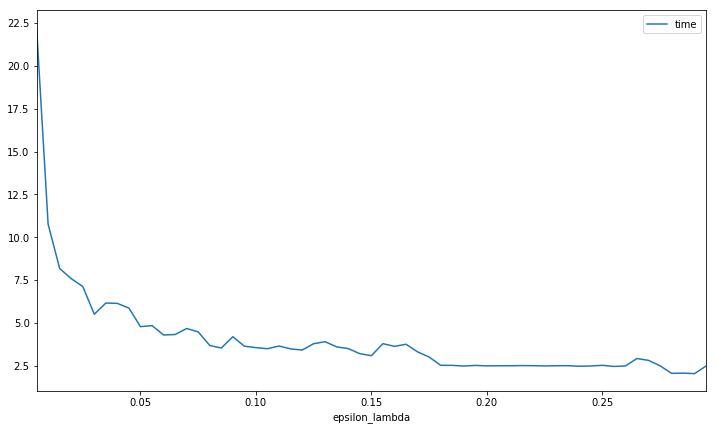

In [280]:
results_white_epslam_df.sort_values(by=['epsilon_lambda']).plot(x ='epsilon_lambda', y='time', kind = 'line',  figsize=(12,7))

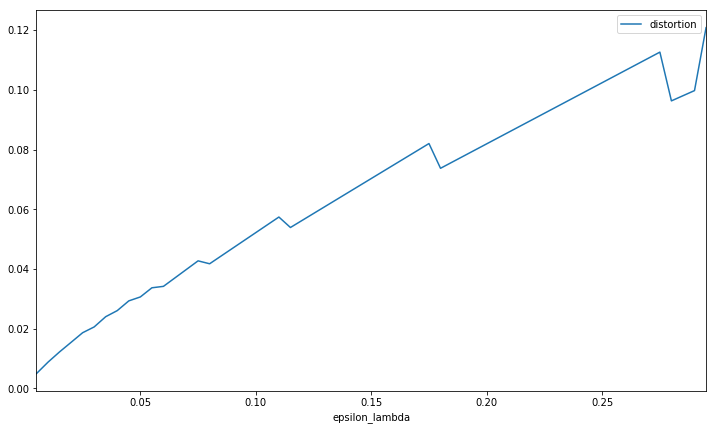

In [281]:
results_white_epslam_df.sort_values(by=['epsilon_lambda']).plot(x ='epsilon_lambda', y='distortion', kind = 'line',  figsize=(12,7))

### Based on results, setting $\gamma = 0.03$, $\epsilon \cdot \lambda = 0.05$

Attack successful.
Attack successful? True
--- distortion =  0.010812879
--- attack time:  4.402148008346558 seconds


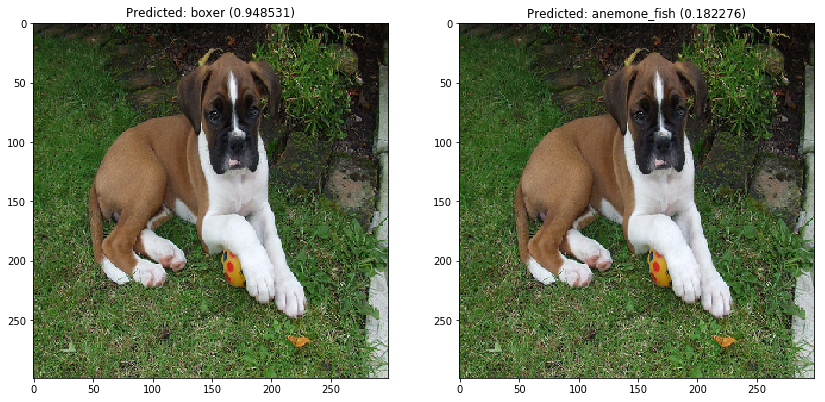

In [284]:
original_image, new_image, time_took, distortion, targetreached = run_whitebox_attack(processed_image_inception_v3, target_class)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- attack time: ",time_took,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

***
## Hyperparameter tuning for whitebox with momentum

Important note: I was time pressured and didn't build in nice parameter tuning functionality in attacks. The following code bits have been ran after modifying attack functions to loop through desired hyperparameter

### Tuning $\gamma$ (from 0.001 to 0.3, increments of 0.001)

In [212]:
results_momentum_gamma = []
results_momentum_gamma = run_whitebox_momentum_attack(processed_image_inception_v3, target_class, results_momentum_gamma)
results_momentum_gamma = pd.DataFrame(results_momentum_gamma, columns=['gamma_t', 'attack_successful','time','distortion'])

running gamma_t  0.001
running gamma_t  0.002
running gamma_t  0.003
running gamma_t  0.004
running gamma_t  0.005
running gamma_t  0.006
running gamma_t  0.007
running gamma_t  0.008
running gamma_t  0.009000000000000001
running gamma_t  0.010000000000000002
running gamma_t  0.011
running gamma_t  0.012
running gamma_t  0.013000000000000001
running gamma_t  0.014000000000000002
running gamma_t  0.015
running gamma_t  0.016
running gamma_t  0.017
running gamma_t  0.018000000000000002
running gamma_t  0.019000000000000003
running gamma_t  0.02
running gamma_t  0.021
running gamma_t  0.022000000000000002
running gamma_t  0.023
running gamma_t  0.024
running gamma_t  0.025
running gamma_t  0.026000000000000002
running gamma_t  0.027000000000000003
running gamma_t  0.028
running gamma_t  0.029
running gamma_t  0.030000000000000002
running gamma_t  0.031
running gamma_t  0.032
running gamma_t  0.033
running gamma_t  0.034
running gamma_t  0.035
running gamma_t  0.036000000000000004
running 

In [ ]:
results_momentum_gamma

In [269]:
print('Number of successful attacks: ', results_momentum_gamma[results_momentum_gamma.attack_successful == True].shape[0])
print('Number of unsuccessful attacks: ', results_momentum_gamma[results_momentum_gamma.attack_successful == False].shape[0])

Number of successful attacks:  458
Number of unsuccessful attacks:  0


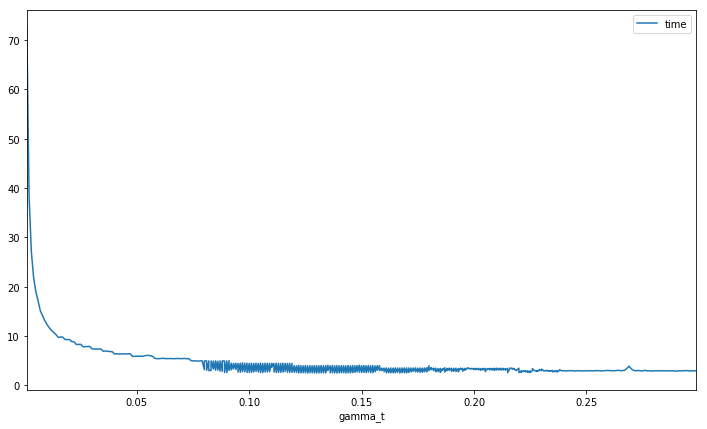

In [249]:
results_momentum_gamma.sort_values(by=['gamma_t']).plot(x ='gamma_t', y='time', kind = 'line',  figsize=(12,7))

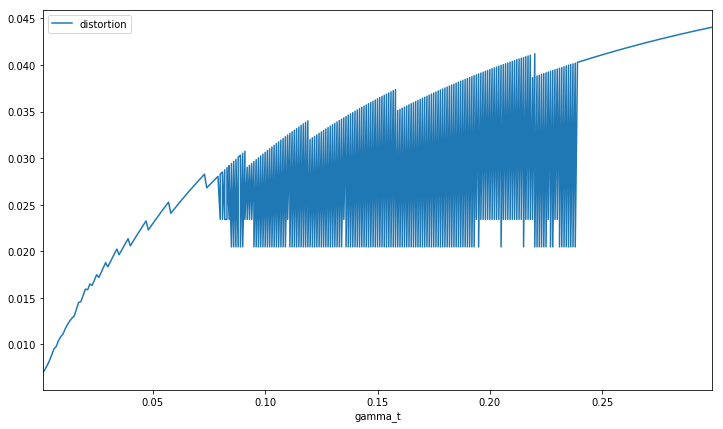

In [250]:
results_momentum_gamma.sort_values(by=['gamma_t']).plot(x ='gamma_t', y='distortion', kind = 'line',  figsize=(12,7))

### Tuning $\beta$ (from 0.8 to 0.99, increments of 0.01)

In [226]:
results_momentum_beta = []
results_momentum_beta = run_whitebox_momentum_attack(processed_image_inception_v3, target_class, results_momentum_beta)
results_momentum_beta_df = pd.DataFrame(results_momentum_beta, columns=['beta', 'attack_successful', 'time', 'distortion'])

running beta  0.8
running beta  0.81
running beta  0.8200000000000001
running beta  0.8300000000000001
running beta  0.8400000000000001
running beta  0.8500000000000001
running beta  0.8600000000000001
running beta  0.8700000000000001
running beta  0.8800000000000001
running beta  0.8900000000000001
running beta  0.9000000000000001
running beta  0.9100000000000001
running beta  0.9200000000000002
running beta  0.9300000000000002
running beta  0.9400000000000002
running beta  0.9500000000000002
running beta  0.9600000000000002
running beta  0.9700000000000002
running beta  0.9800000000000002
running beta  0.9900000000000002


In [272]:
print('Number of successful attacks: ', results_momentum_beta_df[results_momentum_beta_df.attack_successful == True].shape[0])
print('Number of unsuccessful attacks: ', results_momentum_beta_df[results_momentum_beta_df.attack_successful == False].shape[0])

Number of successful attacks:  20
Number of unsuccessful attacks:  0


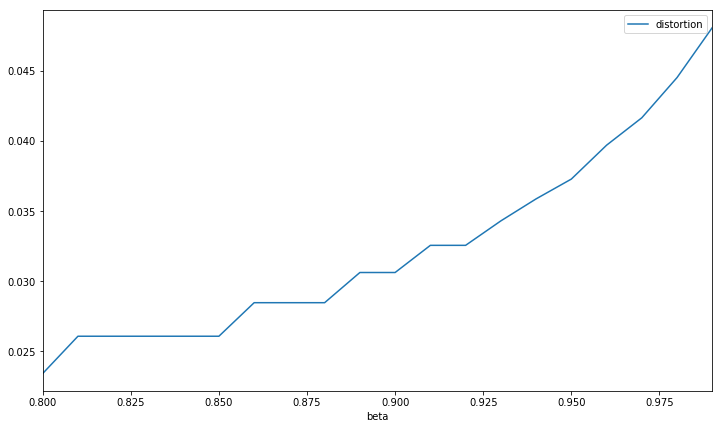

In [233]:
results_momentum_beta_df.plot(x ='beta', y='distortion', kind = 'line',  figsize=(12,7))

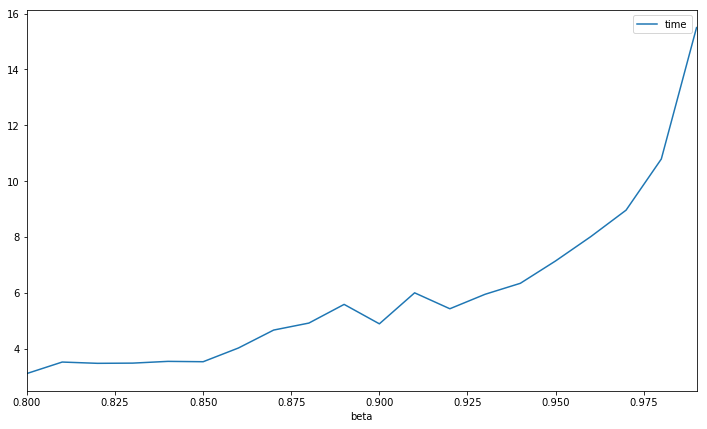

In [234]:
results_momentum_beta_df.plot(x ='beta', y='time', kind = 'line',  figsize=(12,7))

### Tuning $\epsilon$ (from 0.005 to 0.3, increments of 0.005)

In [246]:
results_momentum_epsilon = []
results_momentum_epsilon = run_whitebox_momentum_attack(processed_image_inception_v3, target_class, results_momentum_epsilon)
results_momentum_epsilon_df = pd.DataFrame(results_momentum_epsilon, columns=['epsilon', 'attack_successful', 'time', 'distortion'])

running epsilon  0.005
running epsilon  0.01
running epsilon  0.015
running epsilon  0.02
running epsilon  0.025
running epsilon  0.030000000000000002
running epsilon  0.034999999999999996
running epsilon  0.04
running epsilon  0.045
running epsilon  0.049999999999999996
running epsilon  0.055
running epsilon  0.06
running epsilon  0.065
running epsilon  0.07
running epsilon  0.07500000000000001
running epsilon  0.08
running epsilon  0.085
running epsilon  0.09000000000000001
running epsilon  0.095
running epsilon  0.1
running epsilon  0.10500000000000001
running epsilon  0.11
running epsilon  0.115
running epsilon  0.12000000000000001
running epsilon  0.125
running epsilon  0.13
running epsilon  0.135
running epsilon  0.14
running epsilon  0.14500000000000002
running epsilon  0.15
running epsilon  0.155
running epsilon  0.16
running epsilon  0.165
running epsilon  0.17
running epsilon  0.17500000000000002
running epsilon  0.18000000000000002
running epsilon  0.185
running epsilon  0.1

In [273]:
print('Number of successful attacks: ', results_momentum_epsilon_df[results_momentum_epsilon_df.attack_successful == True].shape[0])
print('Number of unsuccessful attacks: ', results_momentum_epsilon_df[results_momentum_epsilon_df.attack_successful == False].shape[0])

Number of successful attacks:  59
Number of unsuccessful attacks:  0


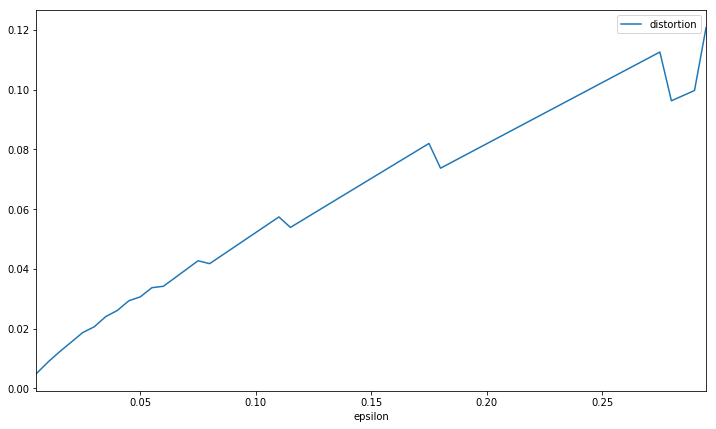

In [247]:
results_momentum_epsilon_df.plot(x ='epsilon', y='distortion', kind = 'line',  figsize=(12,7))

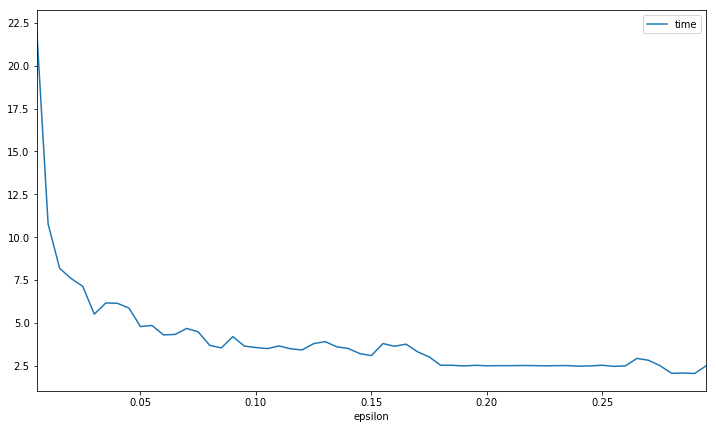

In [248]:
results_momentum_epsilon_df.plot(x ='epsilon', y='time', kind = 'line',  figsize=(12,7))

### Based on results setting $\gamma = 0.05$, $\beta = 0.85$, $\epsilon = 0.1$

running epsilon  0.1
Attack successful? True
--- distortion =  0.030166388
--- attack time:  3.716101884841919 seconds


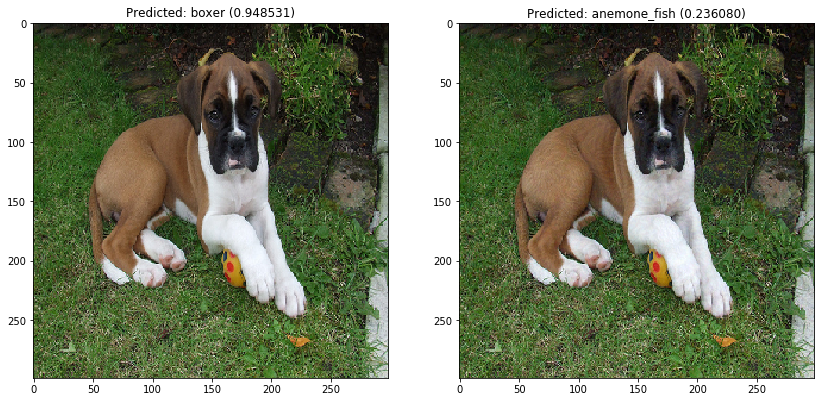

In [254]:
original_image, new_image, time_took, distortion, targetreached = run_whitebox_momentum_attack(processed_image_inception_v3, target_class)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- attack time: ",time_took,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

*** 
## Running multiple attacks (whitebox models)

In [310]:
result_list = []
image_list = []

In [311]:
for experiment in range(0,20):
    print('***********Running experiment: ', experiment,'**************')
    
    # Option 1 : Randomly choose an image
    filename = random.choice(os.listdir("imagenetdata/"))
    
    # Preprocess image
    processed_image_inception_v3 = preprocess_img(filename)

    # What is the ground truth label for this image?
    truelabel = int(filename[0 : filename.find('_')])
    truelabelar = np.zeros((1, 1000))
    truelabelar[0,truelabel] = 1.
    print('*** Ground truth Label is %s, class number %i' % (inception_v3.decode_predictions(truelabelar)[0][0][1], truelabel))
    
    # What is the model predicting now?
    top_predicted_label = inception_v3.decode_predictions(inception_model.predict(processed_image_inception_v3), top=1)[0][0]
    print('*** Predicted Label is %s, with probability %f' % (top_predicted_label[1], top_predicted_label[2]))

    # Has the model got it right?
    predicted_correctly, predicted_label  = run_classification(processed_image_inception_v3, truelabel)
    print('*** Predicted correctly?', predicted_correctly )
    # Generate target randomly

    targets, target_class = generate_target(truelabel)
    print('*** Target Label is %s, class number %i' % (inception_v3.decode_predictions(target_class)[0][0][1], targets))
    filename_ex = [i for i in sorted(os.listdir("imagenetdata/")) if str(targets) == i[0 : i.find('_')]][0]
    example_img = preprocess_img(filename_ex)

    # White box attack
    original_image, new_image, time_took, distortion, targetreached = run_whitebox_attack(processed_image_inception_v3, target_class)
    print('----- White box attack distortion = ', distortion)
    print("----- Attack time: ",time_took,"seconds.")
    
    # Momentum attack
    original_image_m, new_image_m, time_took_m, distortion_m, targetreached_m = run_whitebox_momentum_attack(processed_image_inception_v3, target_class)
    print('----- White box with momentum attack distortion = ', distortion_m)
    print("----- Attack time: ",time_took_m,"seconds.")
    
    result_list.append([experiment, filename, truelabel, targets, time_took, distortion, 
                        targetreached, time_took_m, distortion_m, targetreached_m])
    image_list.append([experiment, example_img, processed_image_inception_v3, new_image, new_image_m])

***********Running experiment:  0 **************
*** Ground truth Label is football_helmet, class number 560
*** Predicted Label is football_helmet, with probability 0.999340
*** Predicted correctly? True
*** Target Label is bathing_cap, class number 433
Attack successful.
----- White box attack distortion =  0.004366398
----- Attack time:  2.094365358352661 seconds.
Attack successful
----- White box with momentum attack distortion =  0.014262557
----- Attack time:  1.6432738304138184 seconds.
***********Running experiment:  1 **************
*** Ground truth Label is tennis_ball, class number 852
*** Predicted Label is Border_collie, with probability 0.178476
*** Predicted correctly? False
*** Target Label is vine_snake, class number 59
Attack successful.
----- White box attack distortion =  0.010812879
----- Attack time:  4.6038429737091064 seconds.
Attack successful
----- White box with momentum attack distortion =  0.026490927
----- Attack time:  3.2810370922088623 seconds.
********

Attack successful
----- White box with momentum attack distortion =  0.036975145
----- Attack time:  4.7630720138549805 seconds.
***********Running experiment:  17 **************
*** Ground truth Label is hourglass, class number 604
*** Predicted Label is hourglass, with probability 0.999750
*** Predicted correctly? True
*** Target Label is seashore, class number 978
----- White box attack distortion =  0.0
----- Attack time:  500.5653440952301 seconds.
----- White box with momentum attack distortion =  0.0
----- Attack time:  5101.426256895065 seconds.
***********Running experiment:  18 **************
*** Ground truth Label is screw, class number 783
*** Predicted Label is screw, with probability 0.974241
*** Predicted correctly? True
*** Target Label is hot_pot, class number 926
Attack successful.
----- White box attack distortion =  0.029329658
----- Attack time:  14.799734115600586 seconds.
Attack successful
----- White box with momentum attack distortion =  0.055987477
----- Attac

In [313]:
results_df = pd.DataFrame(result_list, columns=['experiment_id', 'target_image', 'label','target','white_box_time',
                         'white_box_distortion', 'whitebox_sucessful','momentum_time',
                         'momentum_distortion', 'momentum_successful'])

images_df = pd.DataFrame(image_list, columns=['experiment_id', 'example_image', 'original_image', 'whitebox_image', 'momentum_image'])

In [346]:
results_df

experiment_id                      target_image  label  target  \
0               0  560_ILSVRC2012_val_00045328.JPEG    560     433   
1               1  852_ILSVRC2012_val_00010370.JPEG    852      59   
2               2  649_ILSVRC2012_val_00045483.JPEG    649     247   
3               3  898_ILSVRC2012_val_00049929.JPEG    898     776   
4               4  266_ILSVRC2012_val_00031415.JPEG    266     451   
5               5  530_ILSVRC2012_val_00025849.JPEG    530     999   
6               6  198_ILSVRC2012_val_00019215.JPEG    198     866   
7               7  535_ILSVRC2012_val_00002489.JPEG    535     907   
8               8  262_ILSVRC2012_val_00003691.JPEG    262     655   
9               9  130_ILSVRC2012_val_00038600.JPEG    130     287   
10             10  481_ILSVRC2012_val_00030912.JPEG    481     217   
11             11  171_ILSVRC2012_val_00005471.JPEG    171     961   
12             12  357_ILSVRC2012_val_00012258.JPEG    357     774   
13             13  218_ILSVRC2012_val_00012288.JPEG    218     977   
14             14  257_ILSVRC2012_val_00003794.JPEG    257     944   
15             15  795_ILSVRC2012_val_00011377.JPEG    795     564   
16             16  117_ILSVRC2012_val_00016495.JPEG    117     552   
17             17  604_ILSVRC2012_val_00018841.JPEG    604     978   
18             18  783_ILSVRC2012_val_00040250.JPEG    783     926   
19             19  847_ILSVRC2012_val_00049454.JPEG    847     279   

    white_box_time  white_box_distortion  whitebox_sucessful  momentum_time  \
0         2.094365              0.004366                True       1.643274   
1         4.603843              0.010813                True       3.281037   
2         7.282164              0.016349                True       6.874541   
3         2.433961              0.005735                True       1.651944   
4         2.414169              0.005735                True       2.367132   
5         3.070894              0.007063                True       2.341390   
6         3.659526              0.008351                True       3.603232   
7         3.550053              0.008351                True       3.519542   
8         6.898599              0.016349                True       7.181444   
9        20.202230              0.033800                True       9.878648   
10        4.547414              0.010813                True       4.787291   
11        6.715192              0.015308                True       5.118383   
12        4.580974              0.010813                True       3.555016   
13        7.651587              0.017358                True       4.638467   
14        5.026237              0.011989                True       5.360082   
15        4.656481              0.010813                True       4.245047   
16        5.108148              0.011989                True       4.763072   
17      500.565344              0.000000               False    5101.426257   
18       14.799734              0.029330                True       7.679586   
19       13.826157              0.028690                True       7.436980   

    momentum_distortion  momentum_successful  
0              0.014263                 True  
1              0.026491                 True  
2              0.045964                 True  
3              0.014263                 True  
4              0.018549                 True  
5              0.018549                 True  
6              0.030166                 True  
7              0.030166                 True  
8              0.051233                 True  
9              0.062265                 True  
10             0.036975                 True  
11             0.036975                 True  
12             0.026491                 True  
13             0.036975                 True  
14             0.040126                 True  
15             0.033658                 True  
16             0.036975                 True  
17             0.000000    

In [355]:
print('Base failed an attack in',results_df[results_df.whitebox_sucessful == False].shape[0],'run(s)')
print('Momentum failed an attack in',results_df[results_df.momentum_successful == False].shape[0],'run(s)')

Base failed an attack in  1 runs
Momentum failed an attack in  1 runs


In [360]:
print('Base success rate:',100*results_df[results_df.whitebox_sucessful == True].shape[0]/results_df.shape[0],'%')
print('Momentum success rate:',100*results_df[results_df.momentum_successful == True].shape[0]/results_df.shape[0],'%')

Base success rate:  95.0 %
Momentum success rate:  95.0 %


In [350]:
print('Base was faster in',results_df[results_df.white_box_time < results_df.momentum_time].shape[0],'runs')
print('Momentum was faster in',results_df[results_df.white_box_time > results_df.momentum_time].shape[0],'runs')

Base faster in  4 runs
Momentum faster in  16 runs


In [352]:
print('Base distortion was lower in',results_df[results_df.white_box_distortion < results_df.momentum_distortion].shape[0],'runs')
print('Momentum distrtion was lower in',results_df[results_df.white_box_distortion > results_df.momentum_distortion].shape[0],'runs')

Base distortion lower in  19 runs
Momentum distrtion lower in  0 runs


Experiment  0


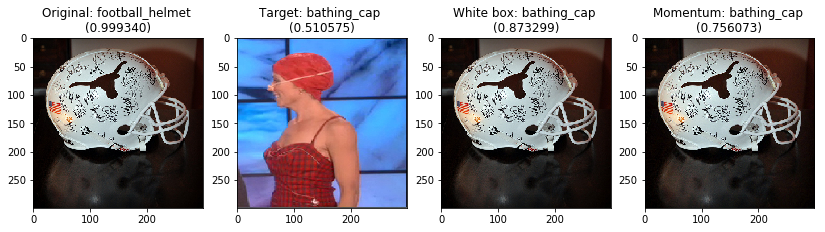

In [339]:
exid = 0
plot_sidebyside_4(images_df.iloc[exid][0], images_df.iloc[exid][2], images_df.iloc[exid][1], images_df.iloc[exid][3], images_df.iloc[exid][4])

Experiment  2


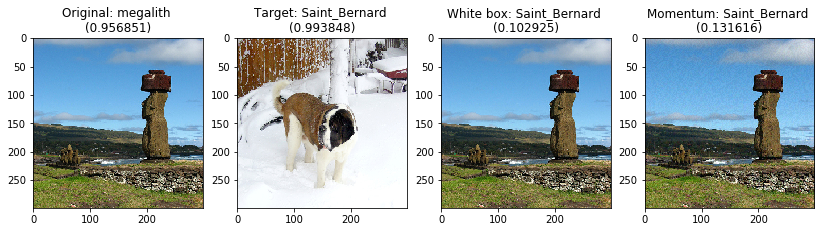

In [340]:
exid = 2
plot_sidebyside_4(images_df.iloc[exid][0], images_df.iloc[exid][2], images_df.iloc[exid][1], images_df.iloc[exid][3], images_df.iloc[exid][4])

Experiment  5


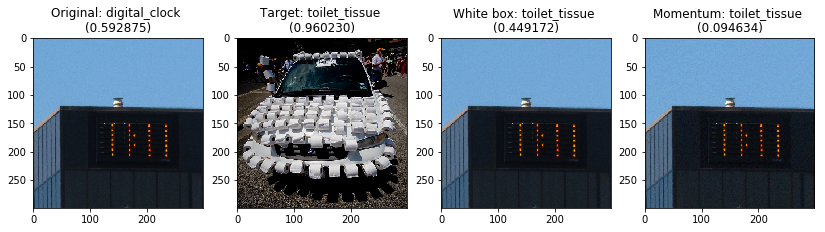

In [323]:
exid = 5
plot_sidebyside_4(images_df.iloc[exid][0], images_df.iloc[exid][2], images_df.iloc[exid][1], images_df.iloc[exid][3], images_df.iloc[exid][4])

Experiment  6


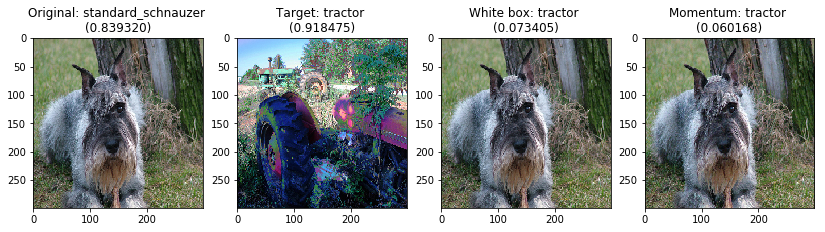

In [341]:
exid = 6
plot_sidebyside_4(images_df.iloc[exid][0], images_df.iloc[exid][2], images_df.iloc[exid][1], images_df.iloc[exid][3], images_df.iloc[exid][4])

Experiment  7


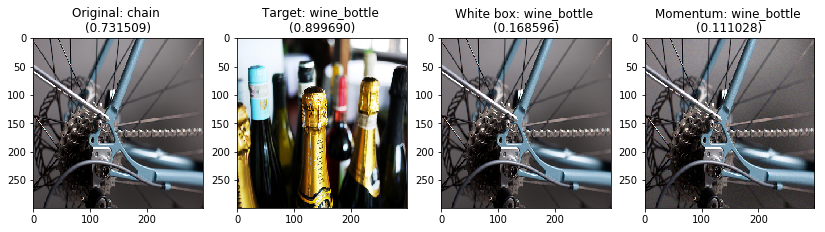

In [326]:
exid = 7
plot_sidebyside_4(images_df.iloc[exid][0], images_df.iloc[exid][2], images_df.iloc[exid][1], images_df.iloc[exid][3], images_df.iloc[exid][4])

Experiment  8


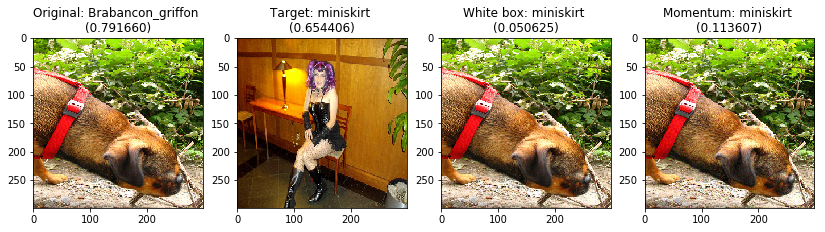

In [342]:
exid = 8
plot_sidebyside_4(images_df.iloc[exid][0], images_df.iloc[exid][2], images_df.iloc[exid][1], images_df.iloc[exid][3], images_df.iloc[exid][4])

Experiment  9


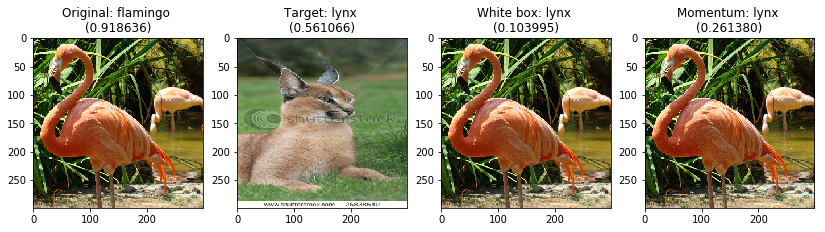

In [328]:
exid = 9
plot_sidebyside_4(images_df.iloc[exid][0], images_df.iloc[exid][2], images_df.iloc[exid][1], images_df.iloc[exid][3], images_df.iloc[exid][4])

Experiment  10


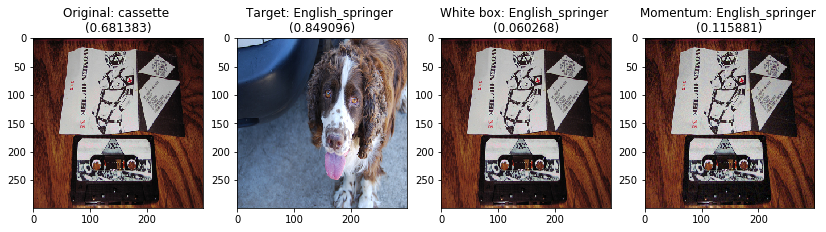

In [343]:
exid = 10
plot_sidebyside_4(images_df.iloc[exid][0], images_df.iloc[exid][2], images_df.iloc[exid][1], images_df.iloc[exid][3], images_df.iloc[exid][4])